In [ ]:
# default_exp core

# Color

> API details.

# Necessary Libraries

In [ ]:
# export
from nbdev.showdoc import *
import seaborn as sns
from matplotlib import colors
from pampy import match, _
from dataclasses import dataclass, astuple
from typing import List, TypeVar, Generic
import numpy as np
import altair as alt
import pandas as pd
import altair as alt
import numpy as np
from vega_datasets import data

np.random.seed(42)
T = TypeVar('T')

# Classes and Functions

## Data Structures

In [ ]:
# export
class Matcher:
    def __init__(self):
        self.pattern = []
    
    def __setitem__(self, pat, method):
        self.pattern.append(pat)
        self.pattern.append(method)
        
    def __call__(self, *x):
        if len(x)==1:
            x = x[0]
        return match(x, *self.pattern)
    

class Multimethod:
    
    def __init__(self):
        pass
    
    def __enter__(self):
        return Matcher()
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        pass

In [ ]:
# export
@dataclass
class Color:
    pass


@dataclass
class HSV(Color):
    H: float
    S: float
    V: float

        
@dataclass
class RGB(Color):
    R: float
    G: float
    B: float
        
Palette = List[Color]

primary_blue = RGB(0, 144/255, 1)
primary_black = RGB(48/255, 64/255, 88/255)

secondary_red = RGB(242/255, 70/255, 110/255)
secondary_orange = RGB(255/255, 141/255, 41/255)
secondary_yellow = RGB(255/255, 209/255, 41/255)
secondary_green = RGB(140/255, 224/255, 36/255)
secondary_blue = RGB(92/255, 214/255, 255/255)
secondary_purple = RGB(135/255, 94/255, 255/255)

secondary_palette = [secondary_blue, secondary_green, 
                     secondary_orange, secondary_purple, 
                     secondary_red, secondary_yellow]

## Functions

In [ ]:
# export
def rgb_hsv(color: RGB) -> HSV:
    return HSV(*colors.rgb_to_hsv((color.R, color.G, color.B)))

def hsv_rgb(color: HSV) -> RGB:
    return RGB(*colors.hsv_to_rgb((color.H, color.S, color.V)))

def palplot(colors: Palette):
    sns.palplot([[c.R, c.G, c.B] for c in colors])

In [ ]:
# export
with Multimethod() as to_rgb:
    to_rgb[RGB] = lambda x : x
    to_rgb[HSV] = lambda x: hsv_rgb(x)
    to_rgb[Palette] = lambda xs: [to_rgb(x) for x in xs]
    
with Multimethod() as to_hsv:
    to_hsv[HSV] = lambda x : x
    to_hsv[RGB] = lambda x: rgb_hsv(x)
    to_hsv[Palette] = lambda xs: [to_hsv(x) for x in xs]
    
with Multimethod() as to_hex:
    to_hex[HSV] = lambda x: colors.rgb2hex(astuple(to_rgb(x)))
    to_hex[RGB] = lambda x: colors.rgb2hex(astuple(x))
    to_hex[Palette] = lambda xs: [to_hex(x) for x in xs] 

In [ ]:
# export
def generate_step_size(i, size1, size2, median=5):
    if i >= median:
        return (i-median)*size1
    else:
        return (i-median)*size2
    
def generate_palette(primary_color: Color, 
                     n_colors:int=5,
                     h_step_size = 0.01,
                     v_step_size1=0.16,
                     v_step_size2=0.05,
                     s_step_size1=0.05,
                     s_step_size2=0.15
                    )-> Palette:
    
    hsv_color = to_hsv(primary_color)
    median = int(n_colors/2)
    return to_rgb([HSV(
        np.clip(hsv_color.H - (-generate_step_size(i, h_step_size, h_step_size, median) if (0.667>hsv_color.H>0.167) else generate_step_size(i, h_step_size, h_step_size, median)),0,1),
        np.clip(hsv_color.S - generate_step_size(i, s_step_size1, s_step_size2, median),0,1), 
        np.clip(hsv_color.V - generate_step_size(i, v_step_size1, v_step_size2, median),0,1)
        )
    for i in range(n_colors)])        

In [ ]:
# export
pal = generate_palette(secondary_green, n_colors=50)

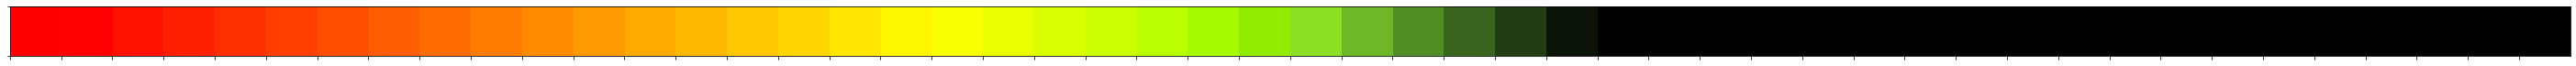

In [ ]:
palplot(pal)

# Applications

## Altair

In [ ]:
# export
def pulsifi_theme():
    # Typography
    font = "Lato"
    # At Urban it's the same font for all text but it's good to keep them separate in case you want to change one later.
    labelFont = "Lato" 
    sourceFont = "Lato"    # Axes
    axisColor = "#000000"
    gridColor = "transparent"
    markColor = to_hex(primary_blue)# Colors
    main_palette = to_hex(secondary_palette)
    sequential_palette = to_hex(pal)
    return {
        # width and height are configured outside the config dict because they are Chart configurations/properties not chart-elements' configurations/properties.
        "width": 685, # from the guide
        "height": 380, # not in the guide
        "config": {
            "title": {
                "fontSize": 18,
                "font": font,
                "anchor": "start", # equivalent of left-aligned.
                "fontColor": "#000000"
            },
            "axisX": {
                "domain": True,
                "domainColor": axisColor,
                "domainWidth": 1,
                "grid": False,
                "labelFont": labelFont,
                "labelFontSize": 12,
                "labelAngle": 0, 
                "tickColor": axisColor,
                "tickSize": 5, # default, including it just to show you can change it
                "titleFont": font,
                "titleFontSize": 12,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "X Axis Title (units)", 
            },
            "axisY": {
                "domain": False,
                "grid": True,
                "gridColor": gridColor,
                "gridWidth": 1,
                "labelFont": labelFont,
                "labelFontSize": 12,
                "labelAngle": 0, 
                "ticks": False, # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 12,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "Y Axis Title (units)", 
                # titles are by default vertical left of axis so we need to hack this 
                "titleAngle": 0, # horizontal
                "titleY": -10, # move it up
                "titleX": 18, # move it to the right so it aligns with the labels 
            },
            "range": {
                "category": main_palette,
                "diverging": sequential_palette,
            },
            "legend": {
                "labelFont": labelFont,
                "labelFontSize": 12,
                "symbolType": "square", # just 'cause
                "symbolSize": 100, # default
                "titleFont": font,
                "titleFontSize": 12,
                "title": "", # set it to no-title by default
                "orient": "top-left", # so it's right next to the y-axis
                "offset": 0, # literally right next to the y-axis.
            },
            "mark":{'color':to_hex(primary_blue), "fill":to_hex(primary_blue)},
            "bar":{'size':30}
            }
    }


In [ ]:
#export
def setup_altair():
    alt.themes.register("pulsifi_theme", pulsifi_theme)
    alt.themes.enable("pulsifi_theme")

In [ ]:
source = data.iowa_electricity()

alt.Chart(source).mark_area().encode(
    x="year:T",
    y="net_generation:Q",
    color="source:O"#{"field":"source", "type":"numeric"}
)

alt.Chart(...)

In [ ]:
source = data.movies()

alt.Chart(source).mark_bar().encode(
    alt.X("IMDB_Rating:Q", bin=True),
    y='count()',tooltip=["count()"]
).interactive()


alt.Chart(...)

## Seaborn

In [ ]:
# export
def setup_seaborn():
    sns.set_palette(to_hex(secondary_palette))

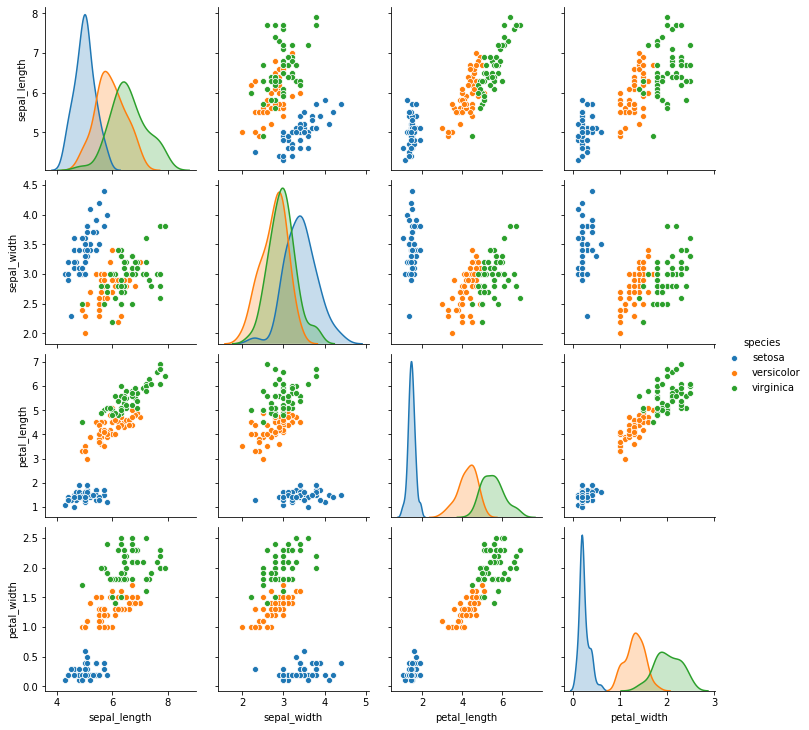

In [ ]:
df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")

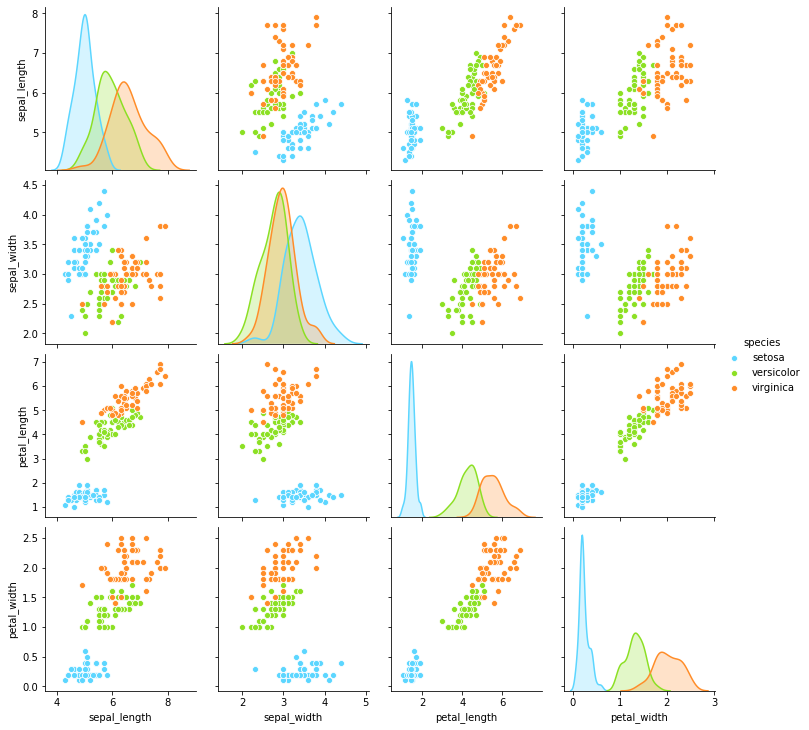

In [ ]:
setup_seaborn()
df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")